## Defining Source

Lets define what source types are exist in nearby of the research area. Based on our study we conclude 2 main faults:
```
1. West Molucca Sea, subduction, reverse, 30, 3, 18, 7.9
2. East Molucca Sea, subduction, reverse, 40, 3, 18, 8.1
```
We will load the fault points:
### Loading Fault Trace

In [1]:
import pandas as pd

fault_table = pd.read_csv("../../fault_source/compiled_source.csv", delimiter=",")
fault_table # preview

code        x      y
0   WMS  124.520  0.050
1   WMS  125.182  0.800
2   WMS  125.270  0.900
3   WMS  125.490  1.280
4   WMS  125.680  2.000
5   WMS  125.723  2.425
6   WMS  125.920  3.080
7   WMS  126.094  3.941
8   WMS  126.118  4.562
9   WMS  126.073  4.963
10  EMS  126.800 -1.070
11  EMS  126.841 -0.308
12  EMS  126.790  0.040
13  EMS  126.760  0.490
14  EMS  126.890  0.980
15  EMS  127.100  1.470
16  EMS  127.574  2.351
17  EMS  127.740  2.660

Lets create fault trace using `hazardlib`

In [2]:
from openquake.hazardlib.geo import Point,Line

# fault trace for west molucca sea
fault_table_WMS = fault_table[fault_table.code == "WMS"]
fault_trace_WMS = Line([Point(x,y) for x,y in zip(fault_table_WMS['x'], fault_table_WMS['y'])])

# fault trace for east molucca sea
fault_table_EMS = fault_table[fault_table.code == "EMS"]
fault_trace_EMS = Line([Point(x,y) for x,y in zip(fault_table_EMS['x'], fault_table_EMS['y'])])

### Creating Fault Source Model
After creating fault trace we can create the fault source model:

In [3]:
from openquake.hazardlib.source import SimpleFaultSource
from openquake.hazardlib.mfd import TruncatedGRMFD 
from openquake.hazardlib.scalerel import WC1994
from openquake.hazardlib.tom import PoissonTOM

src_WMS = SimpleFaultSource(
    source_id='1',
    name='West Molucca Sea',
    tectonic_region_type='Active Shallow Crust',
    mfd=TruncatedGRMFD(min_mag=5., max_mag=7.9, bin_width=0.2, a_val=3.45, b_val=0.98), #get it from catalogue processing
    rupture_mesh_spacing=2.,
    magnitude_scaling_relationship=WC1994(),
    rupture_aspect_ratio=1.,
    temporal_occurrence_model=PoissonTOM(50.),
    upper_seismogenic_depth=3.,
    lower_seismogenic_depth=18.,
    fault_trace=fault_trace_WMS,
    dip=30.,
    rake=90.
)

src_EMS = SimpleFaultSource(
    source_id='2',
    name='East Molucca Sea',
    tectonic_region_type='Active Shallow Crust',
    mfd=TruncatedGRMFD(min_mag=5., max_mag=8.1, bin_width=0.2, a_val=3.45, b_val=0.98), #get it from catalogue processing
    rupture_mesh_spacing=2.,
    magnitude_scaling_relationship=WC1994(),
    rupture_aspect_ratio=1.,
    temporal_occurrence_model=PoissonTOM(50.),
    upper_seismogenic_depth=3.,
    lower_seismogenic_depth=18.,
    fault_trace=fault_trace_EMS,
    dip=40.,
    rake=90.
)

/home/gamant/job/psha/openquake/notebook/processing/utility/fault_plot.py:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  boundaries = numpy.array(boundaries)


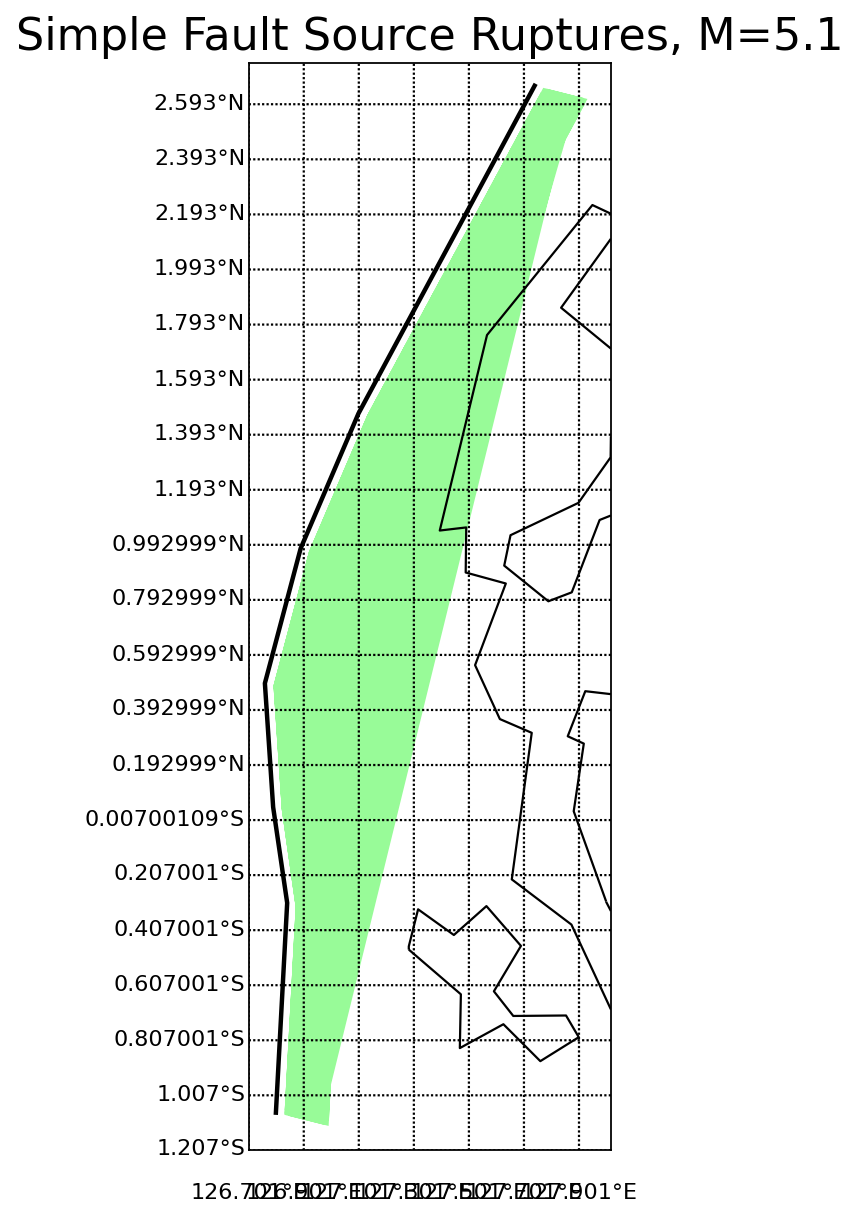

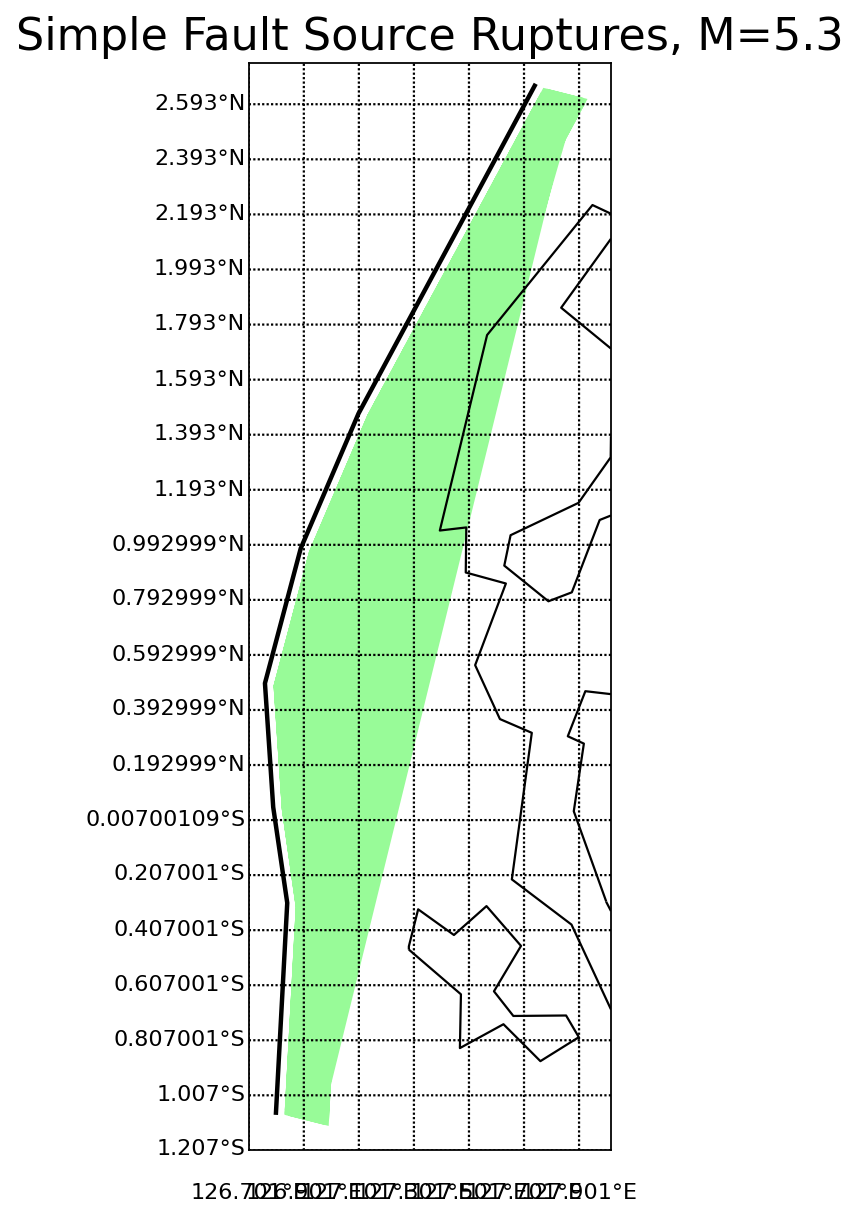

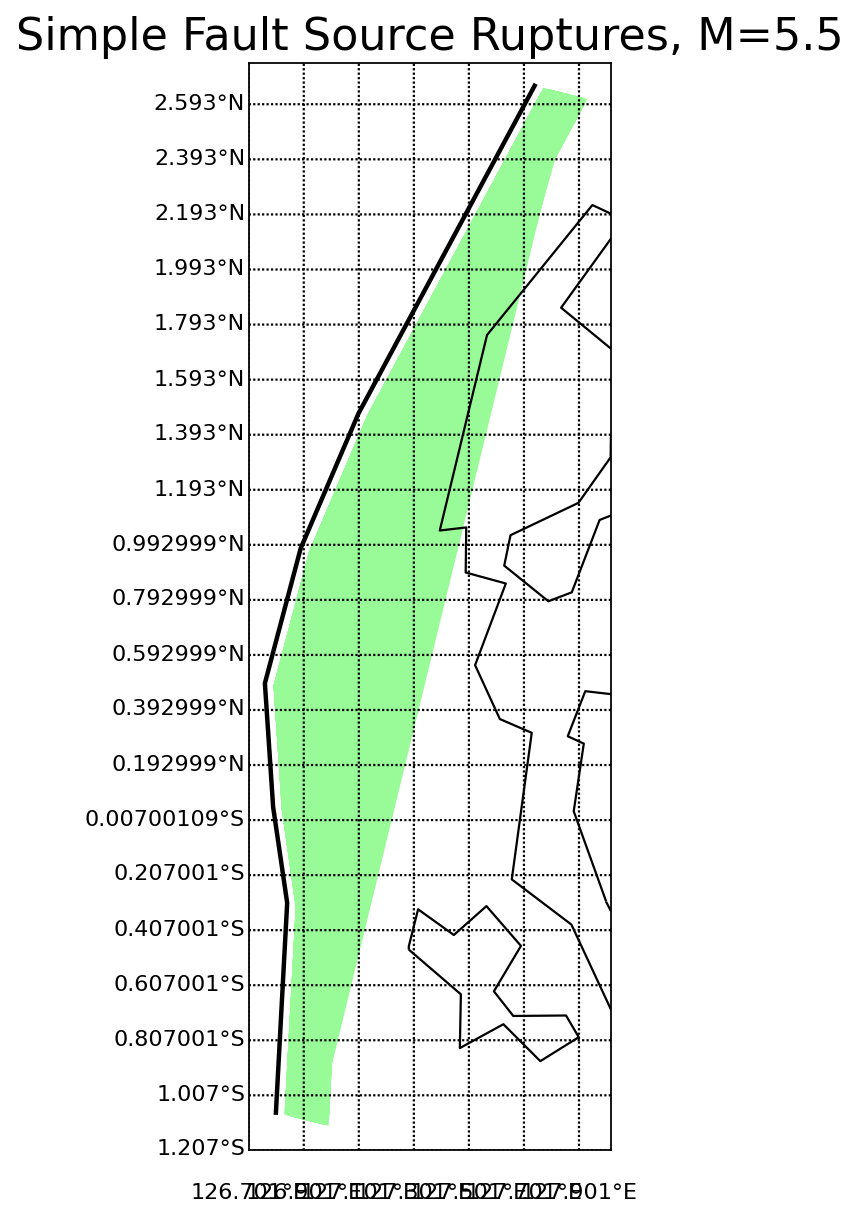

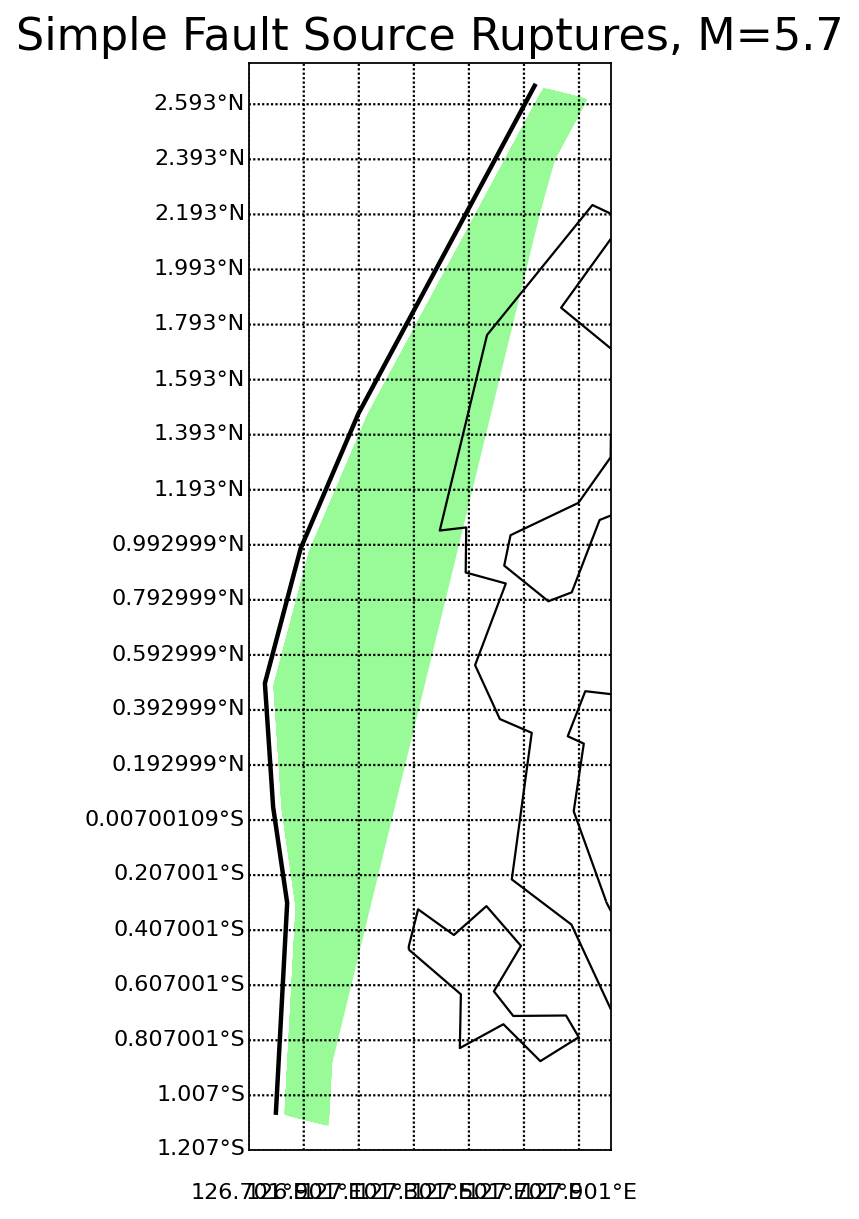

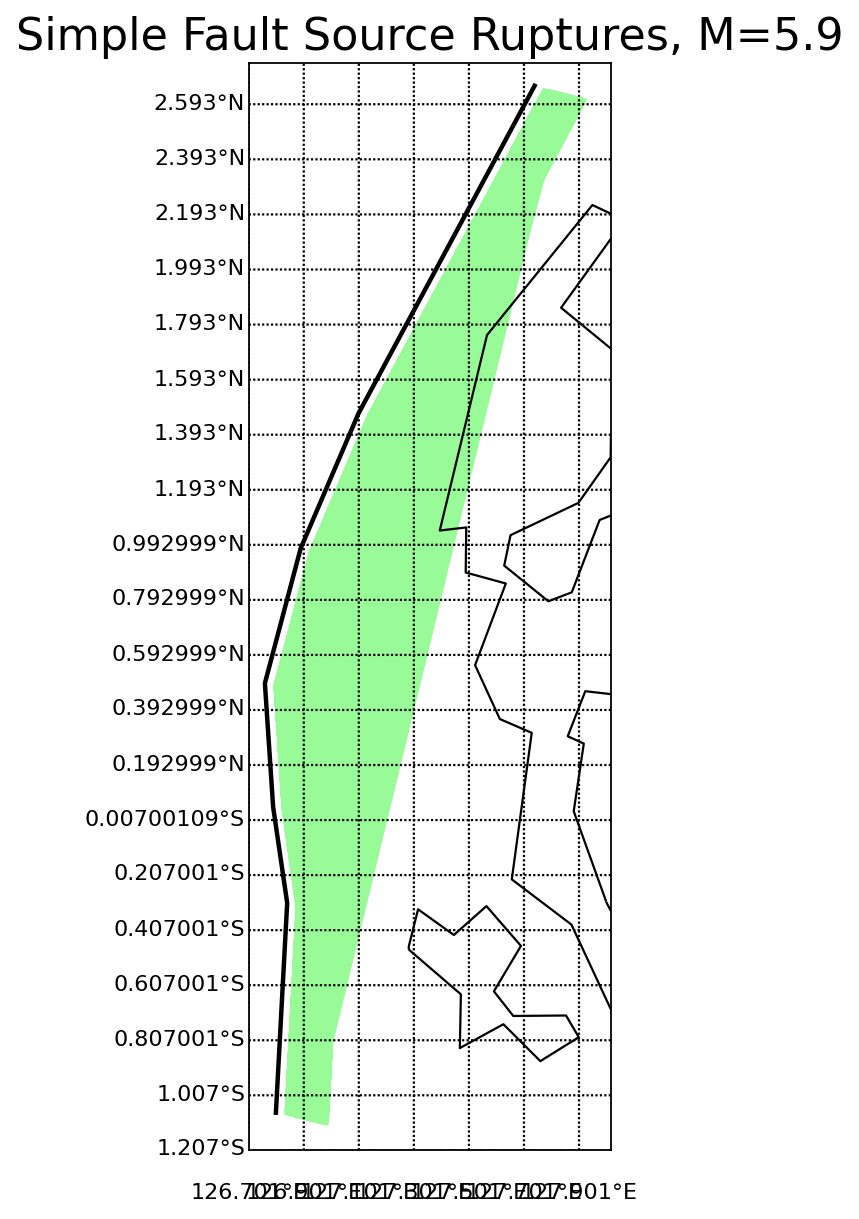

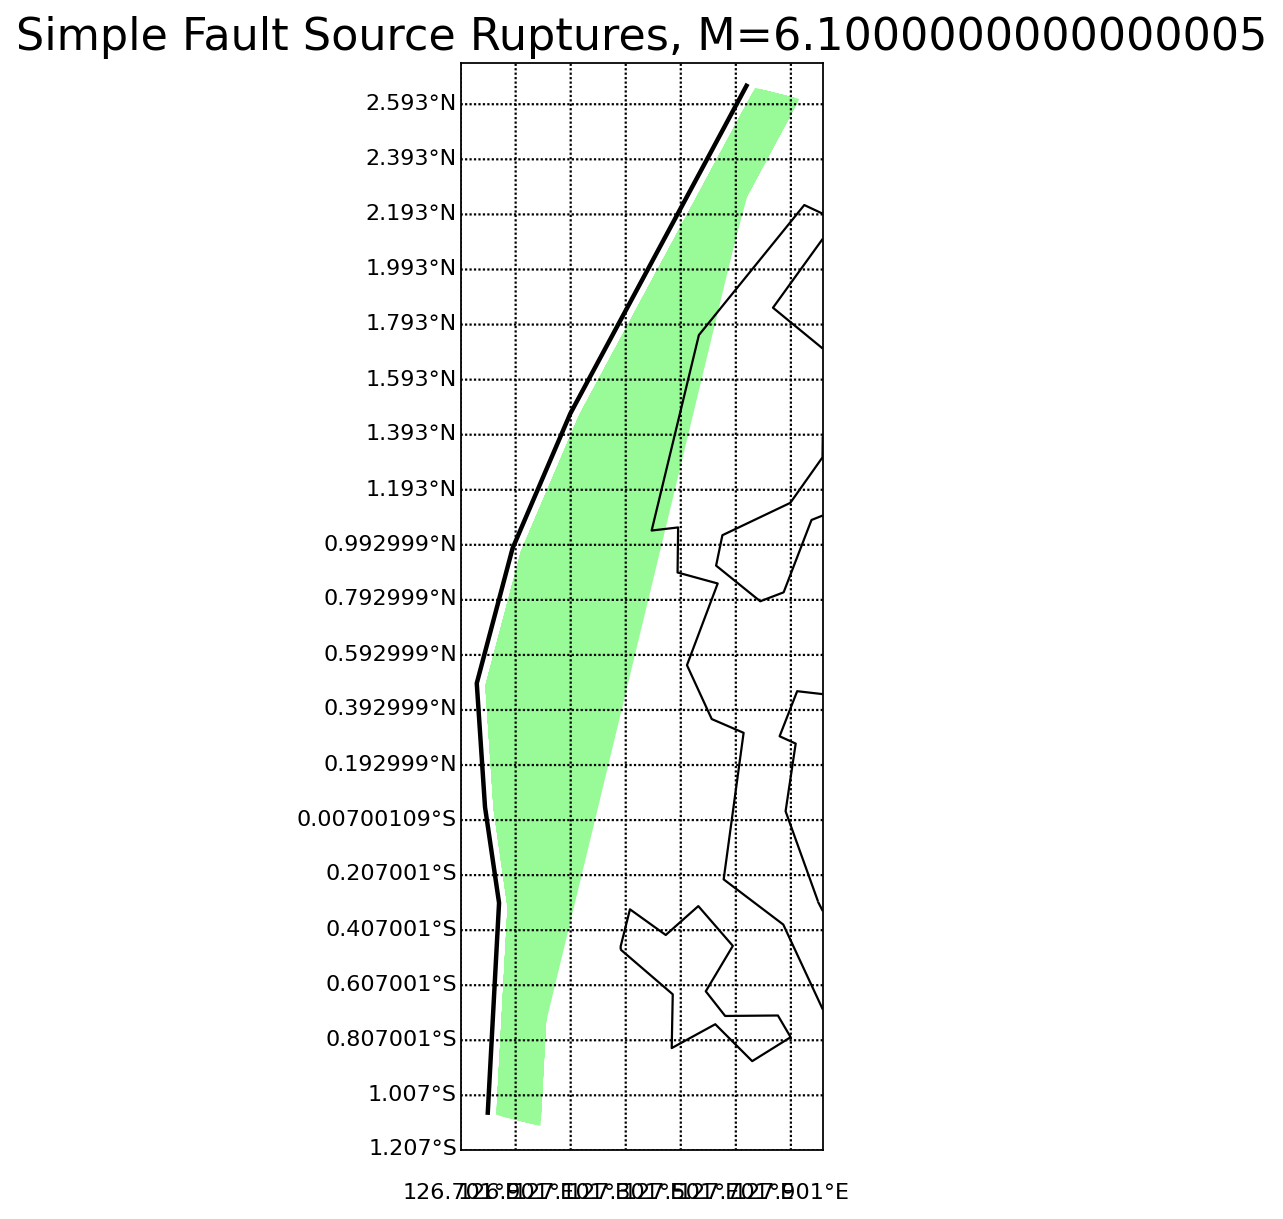

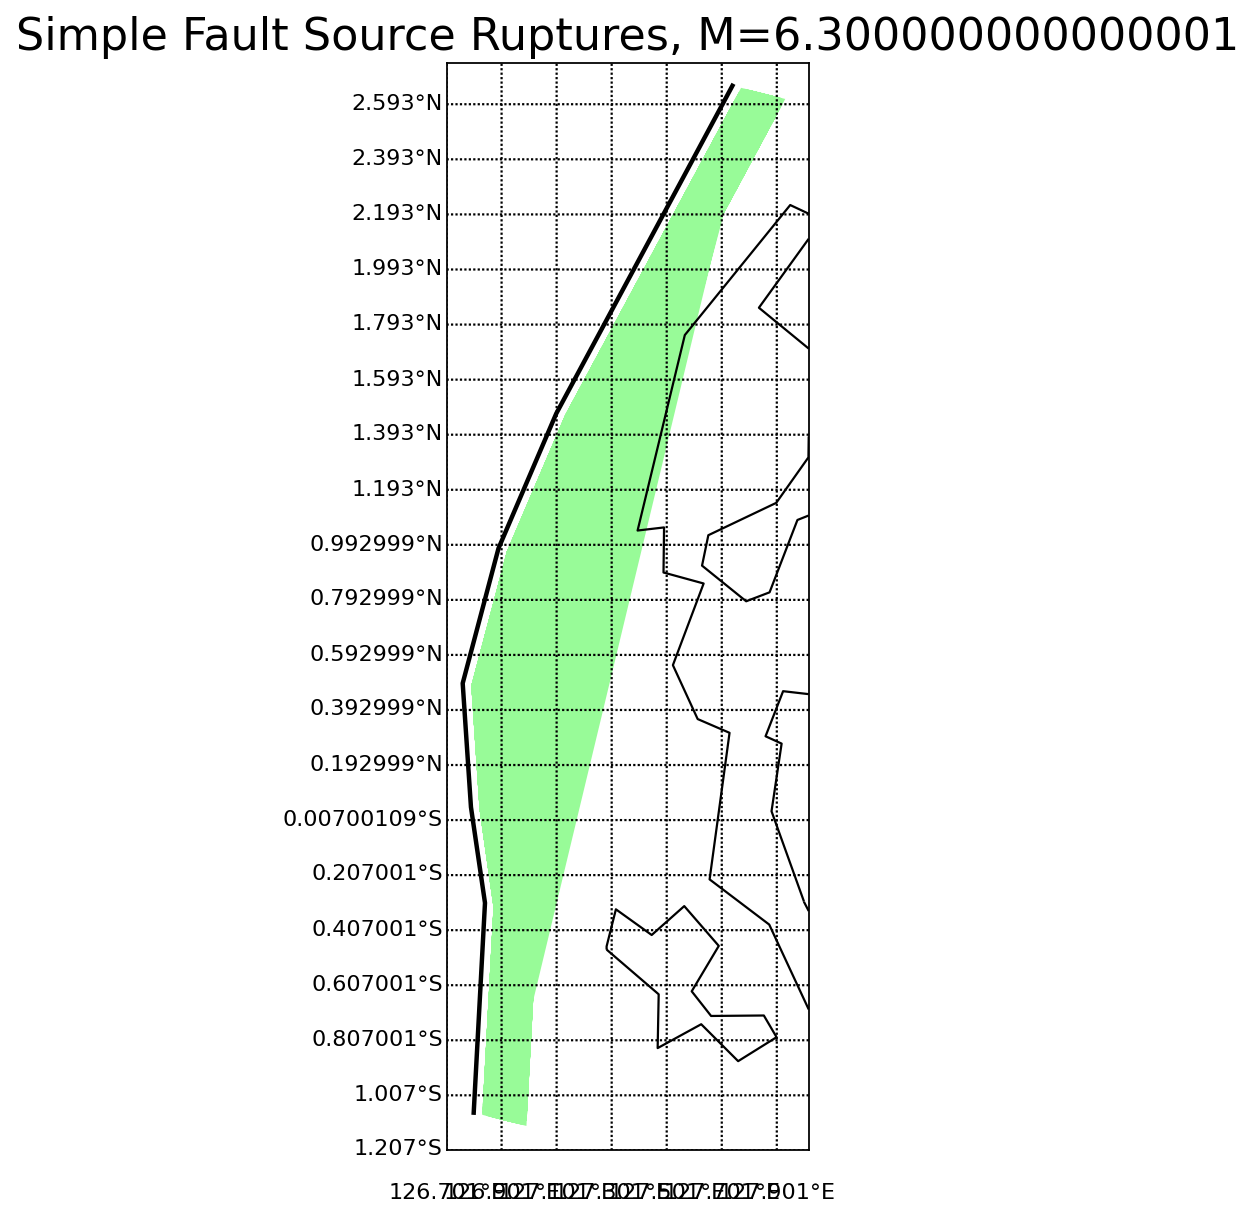

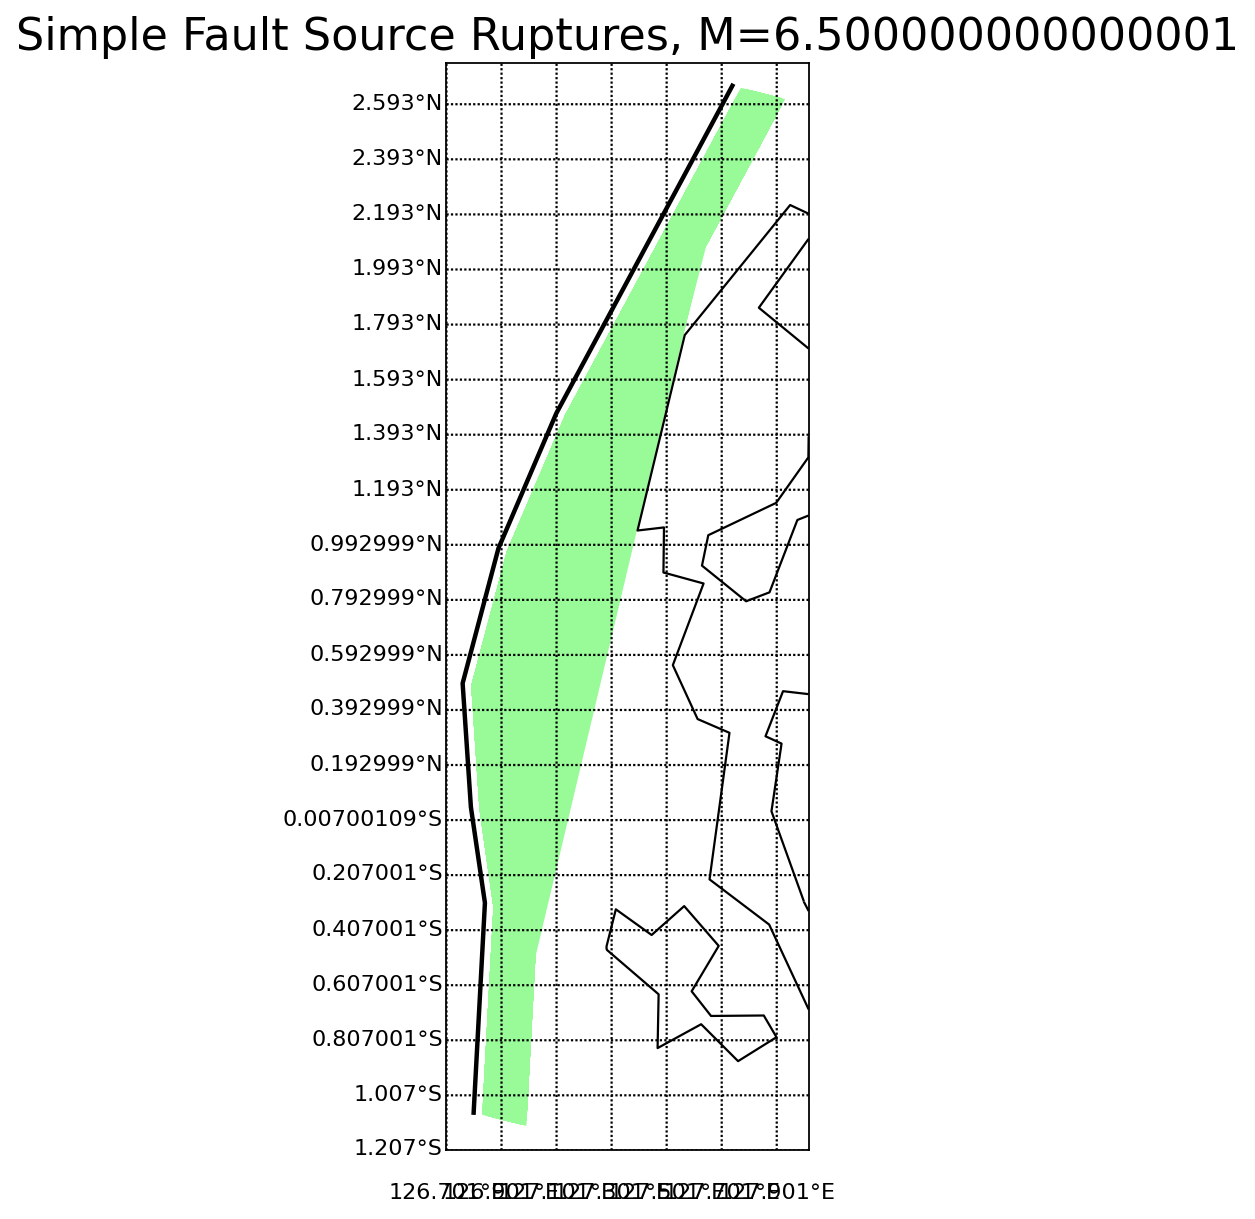

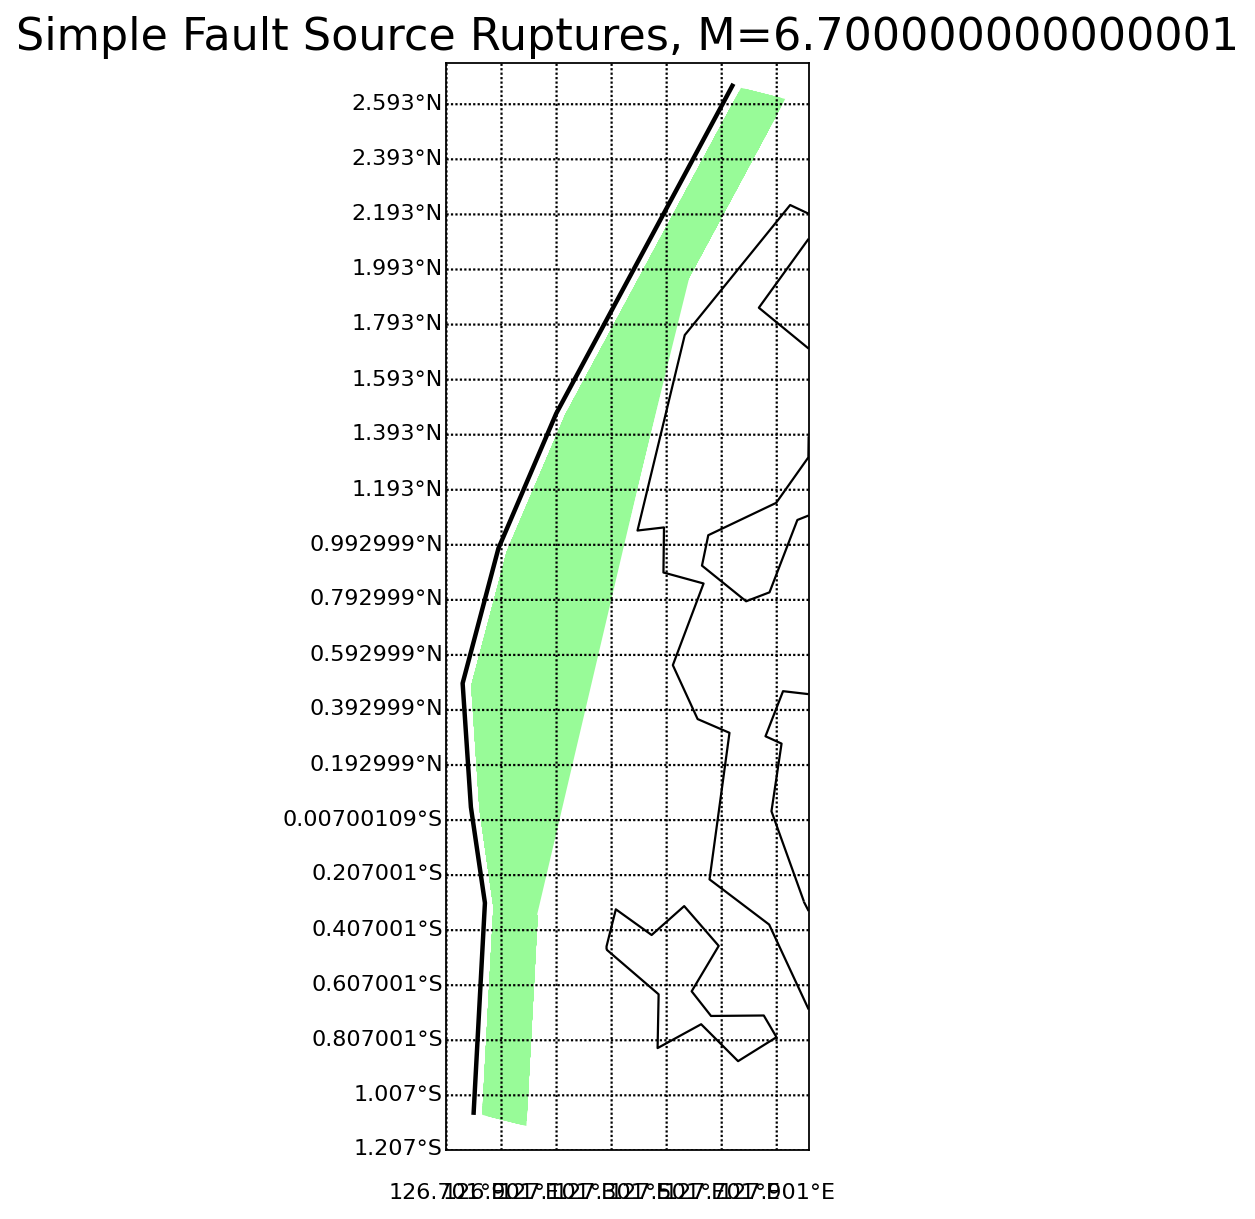

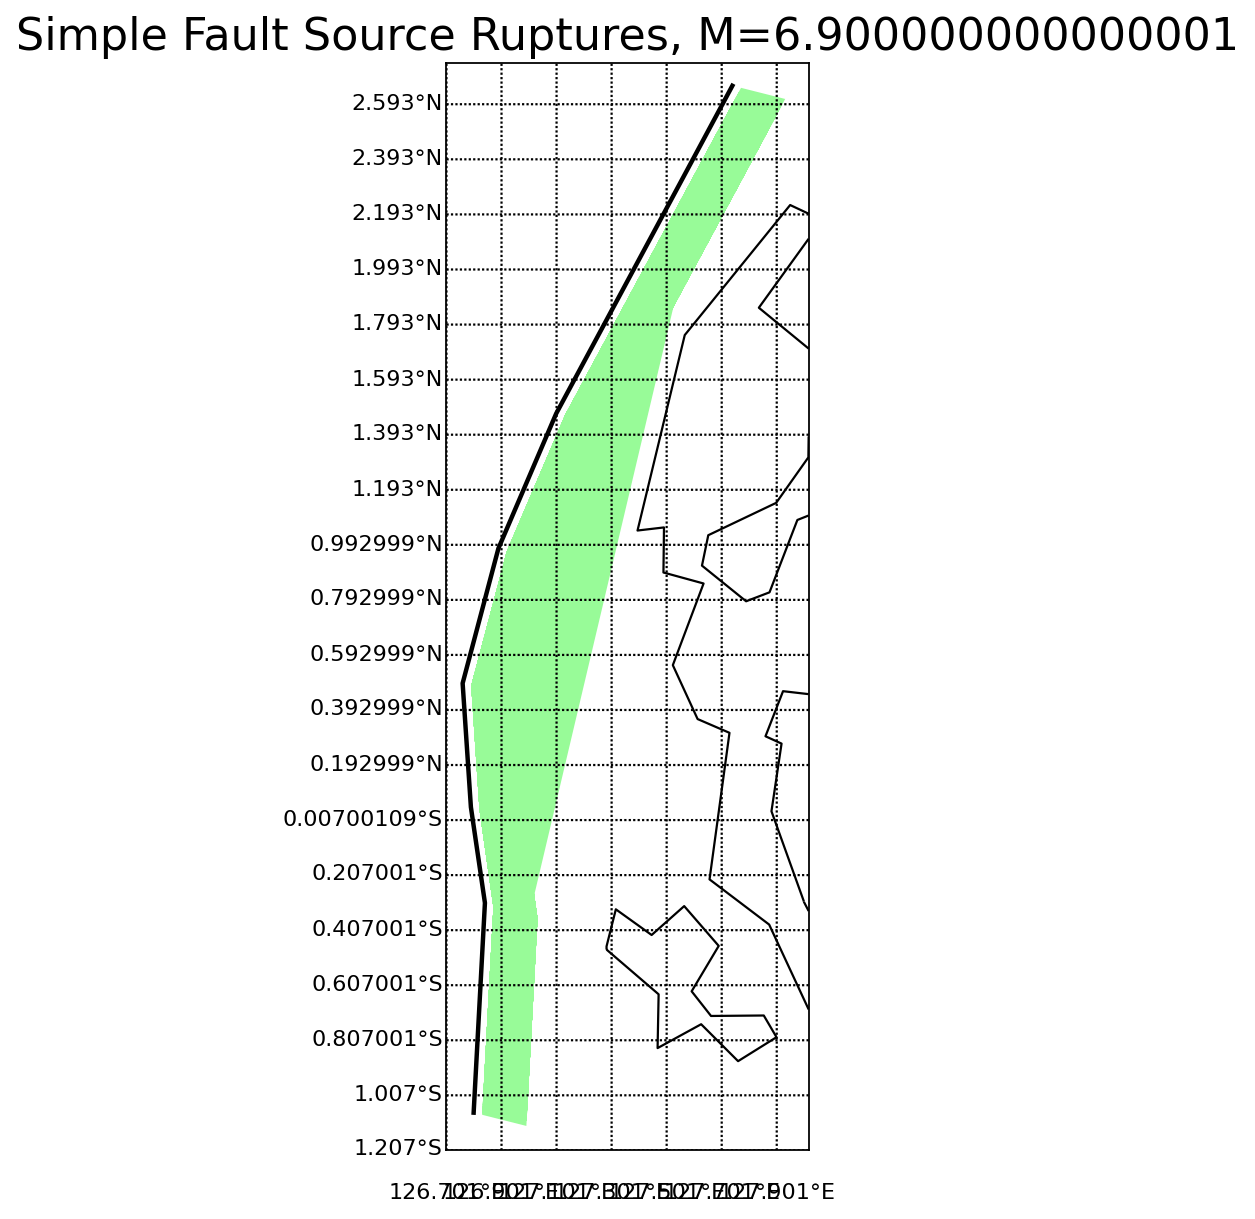

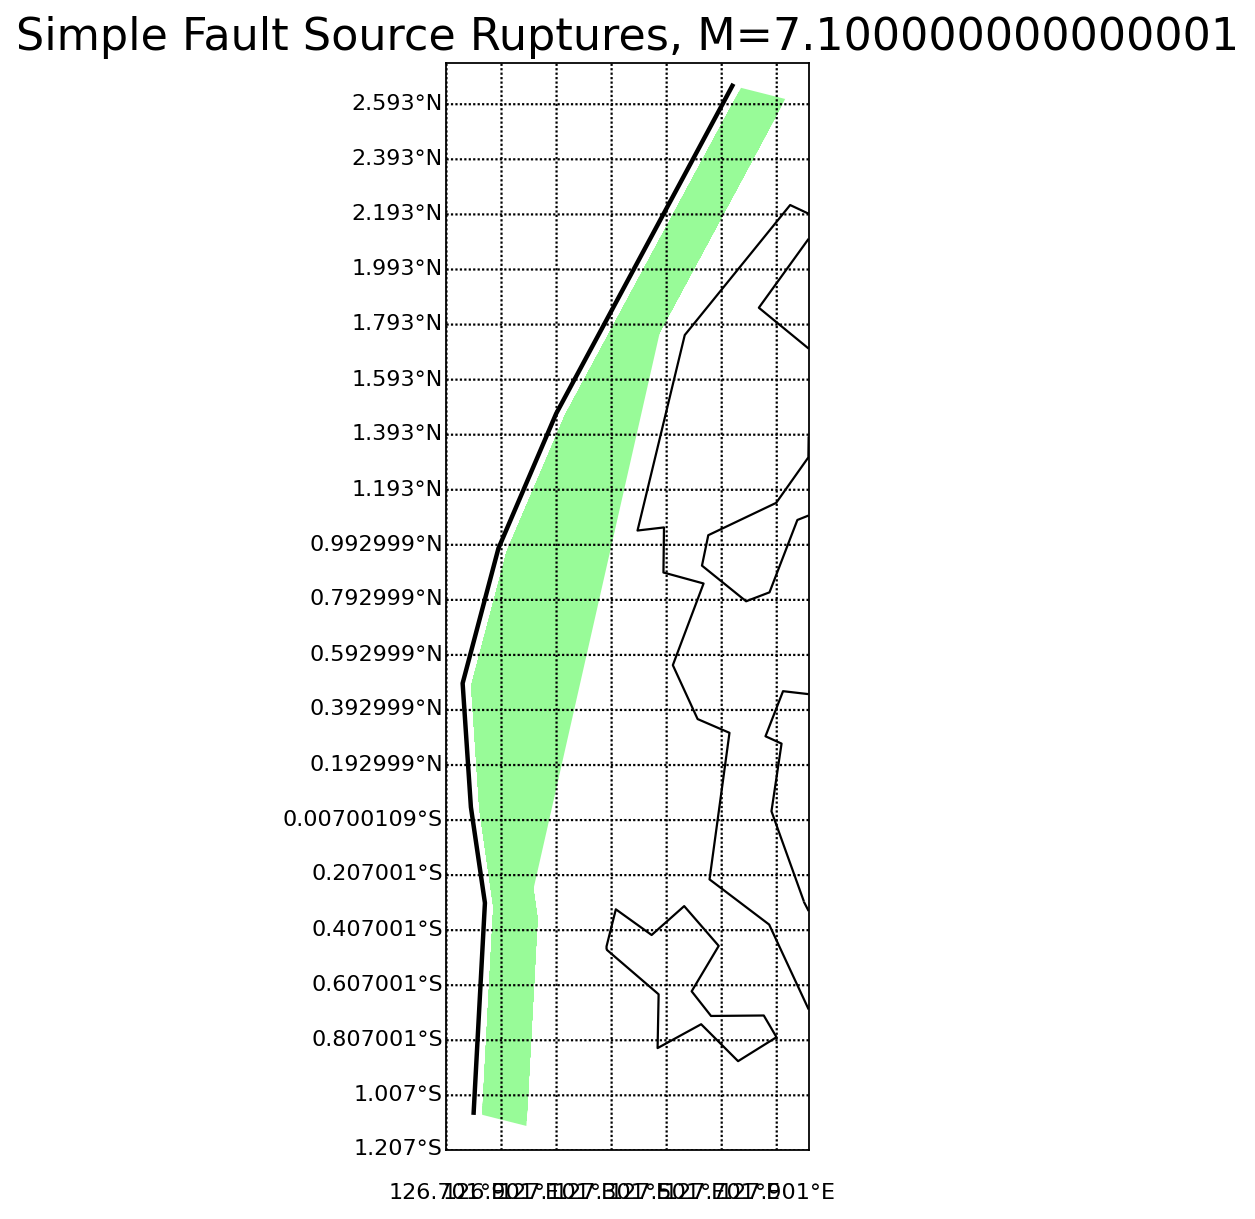

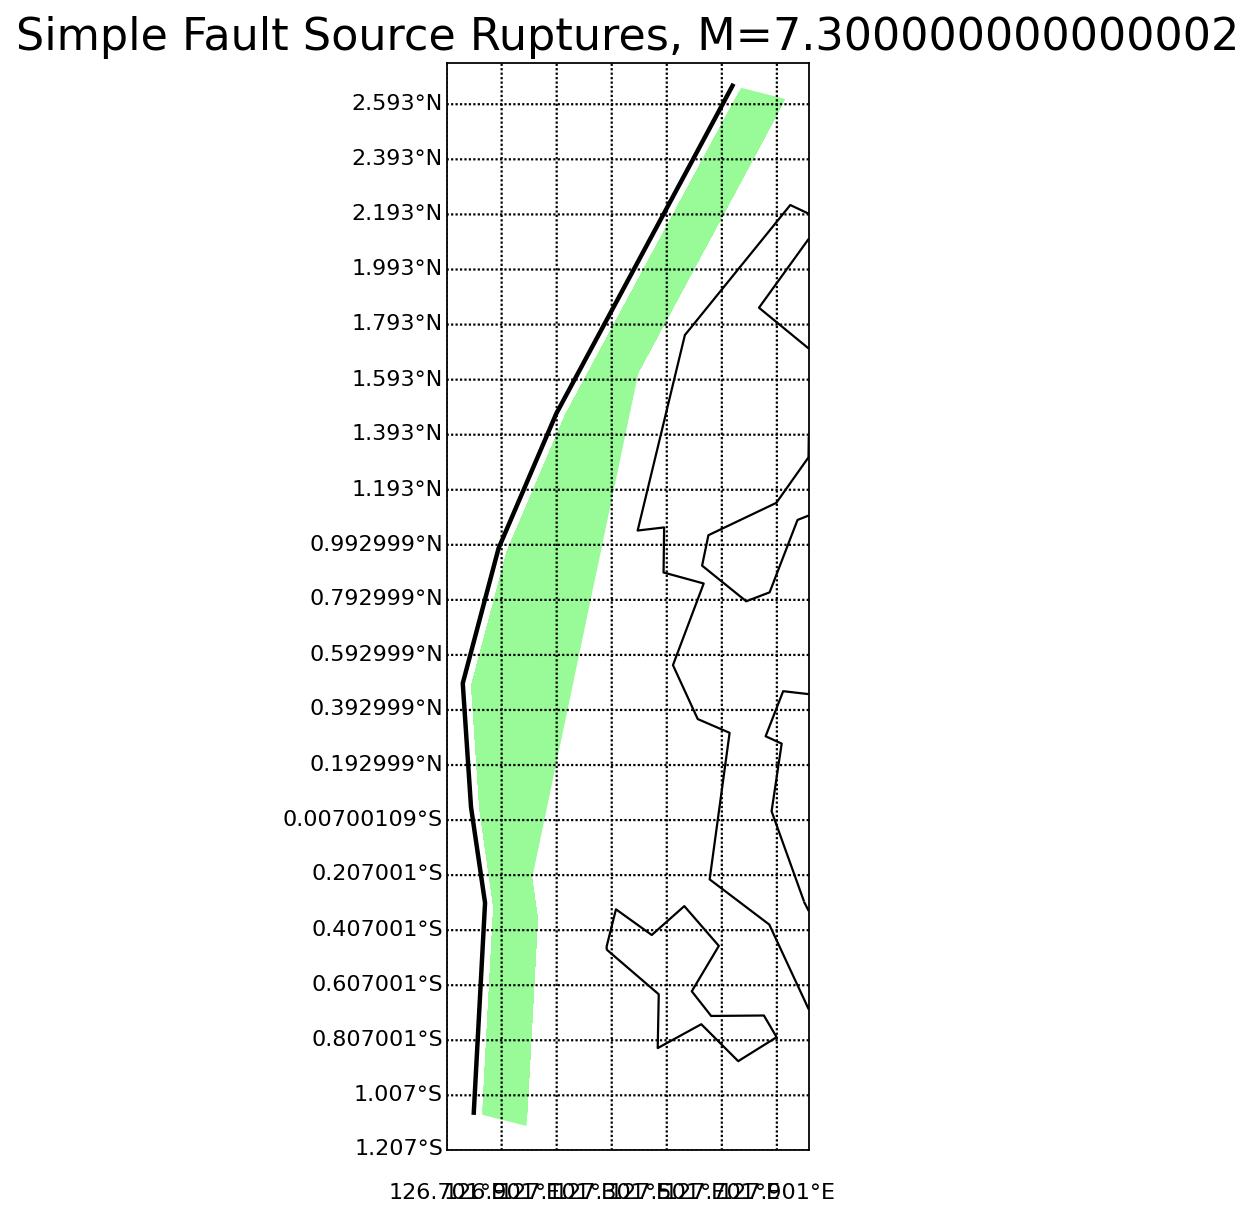

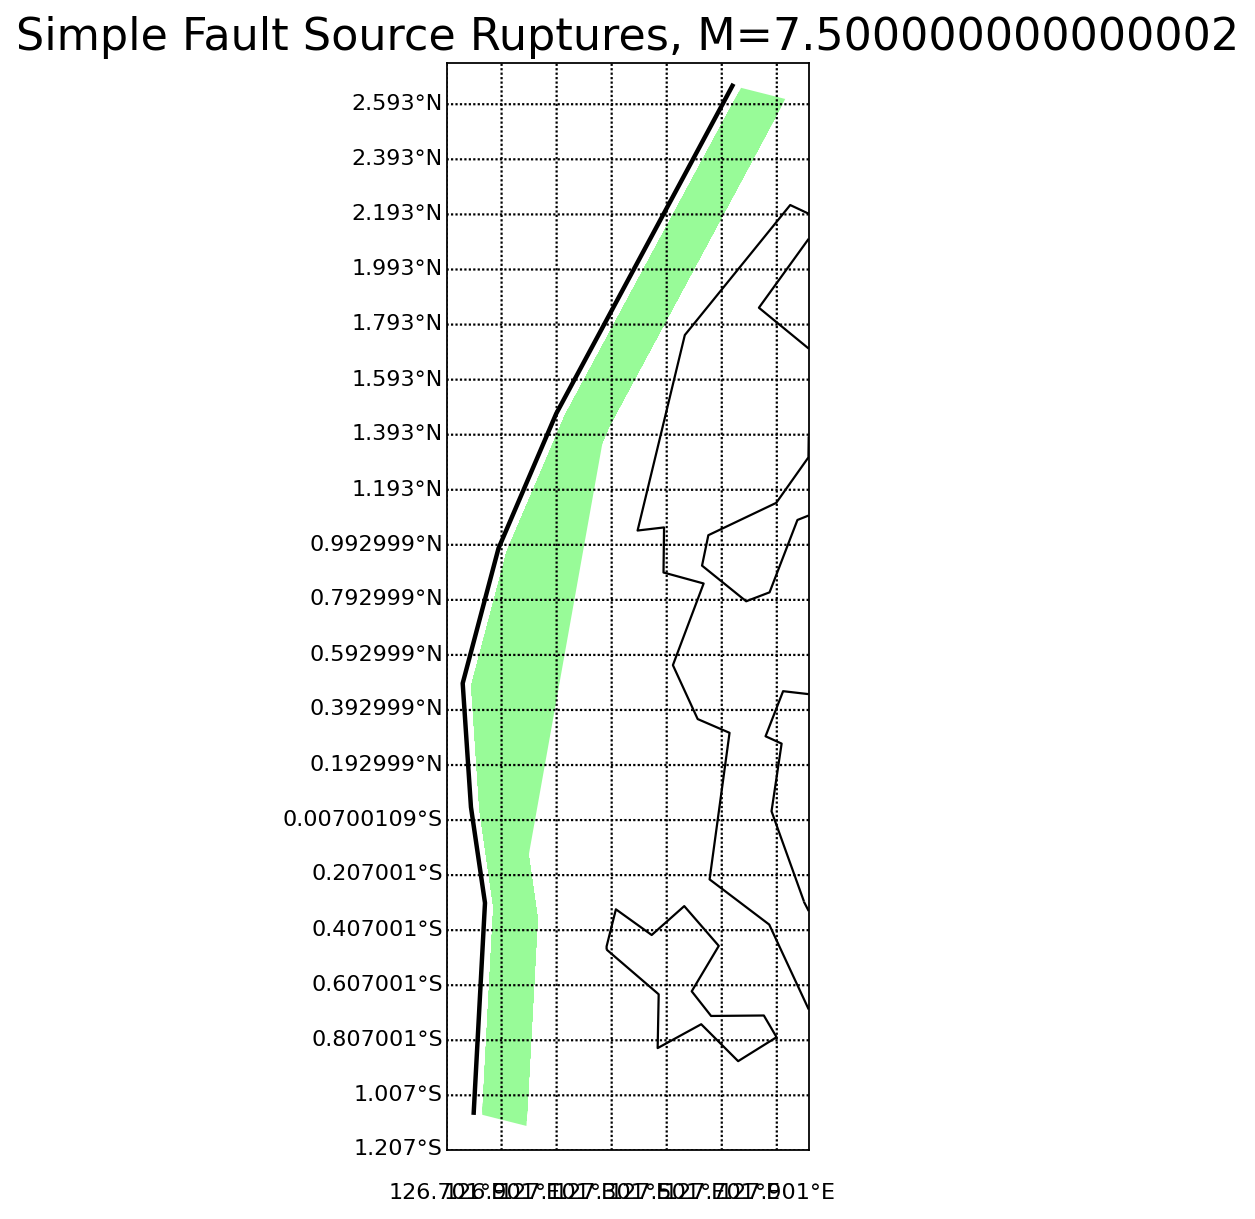

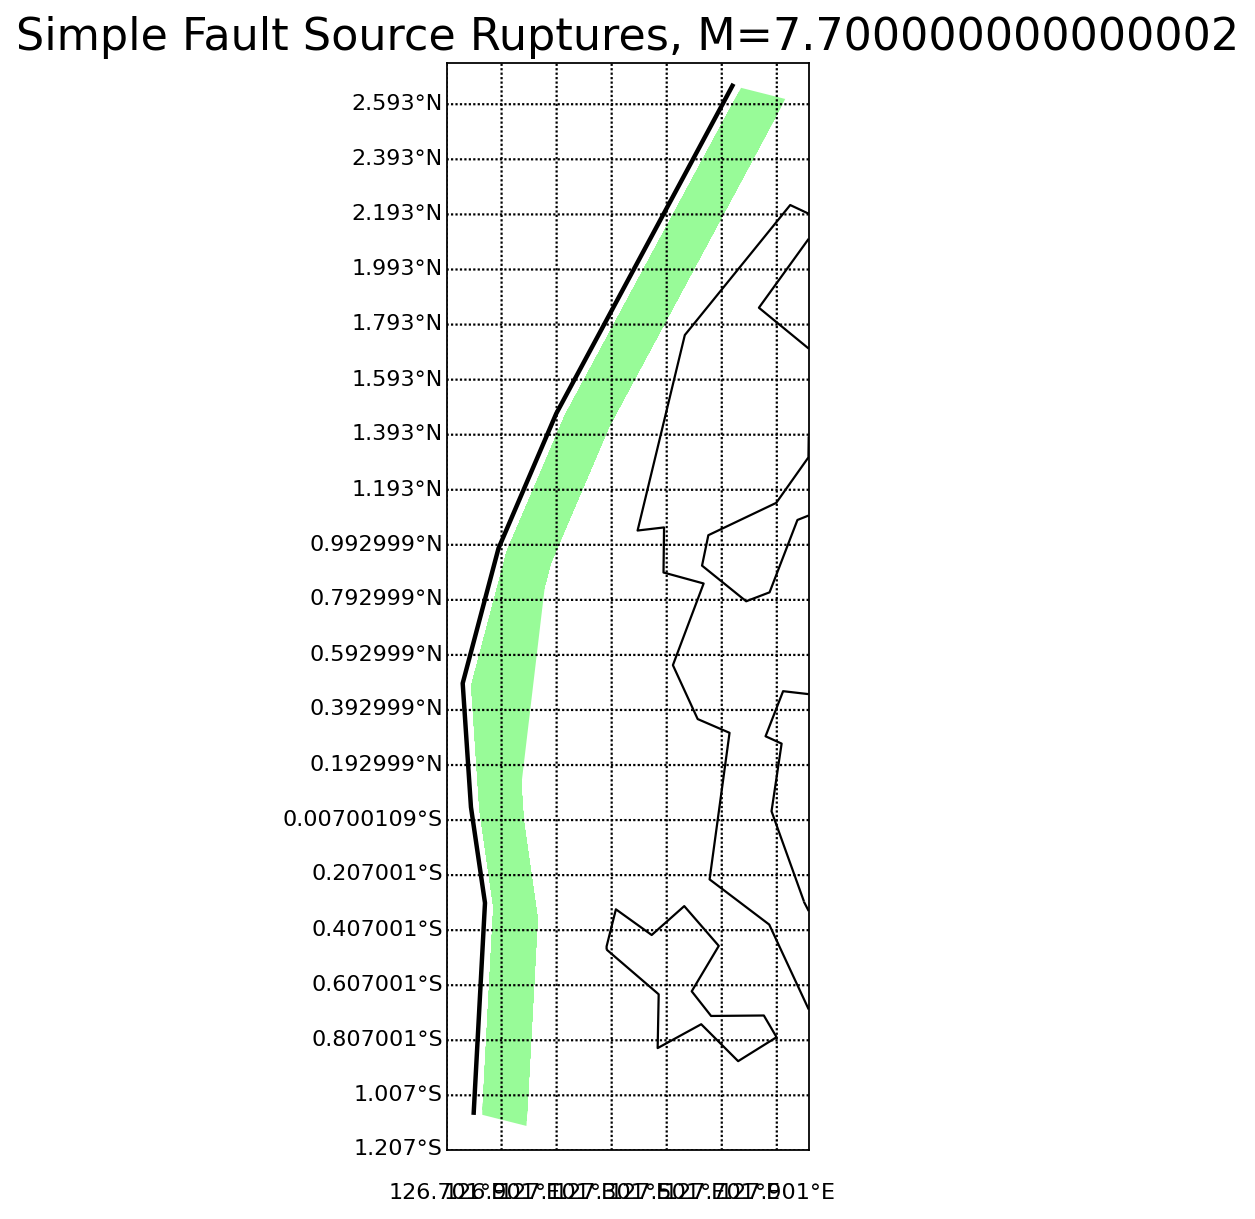

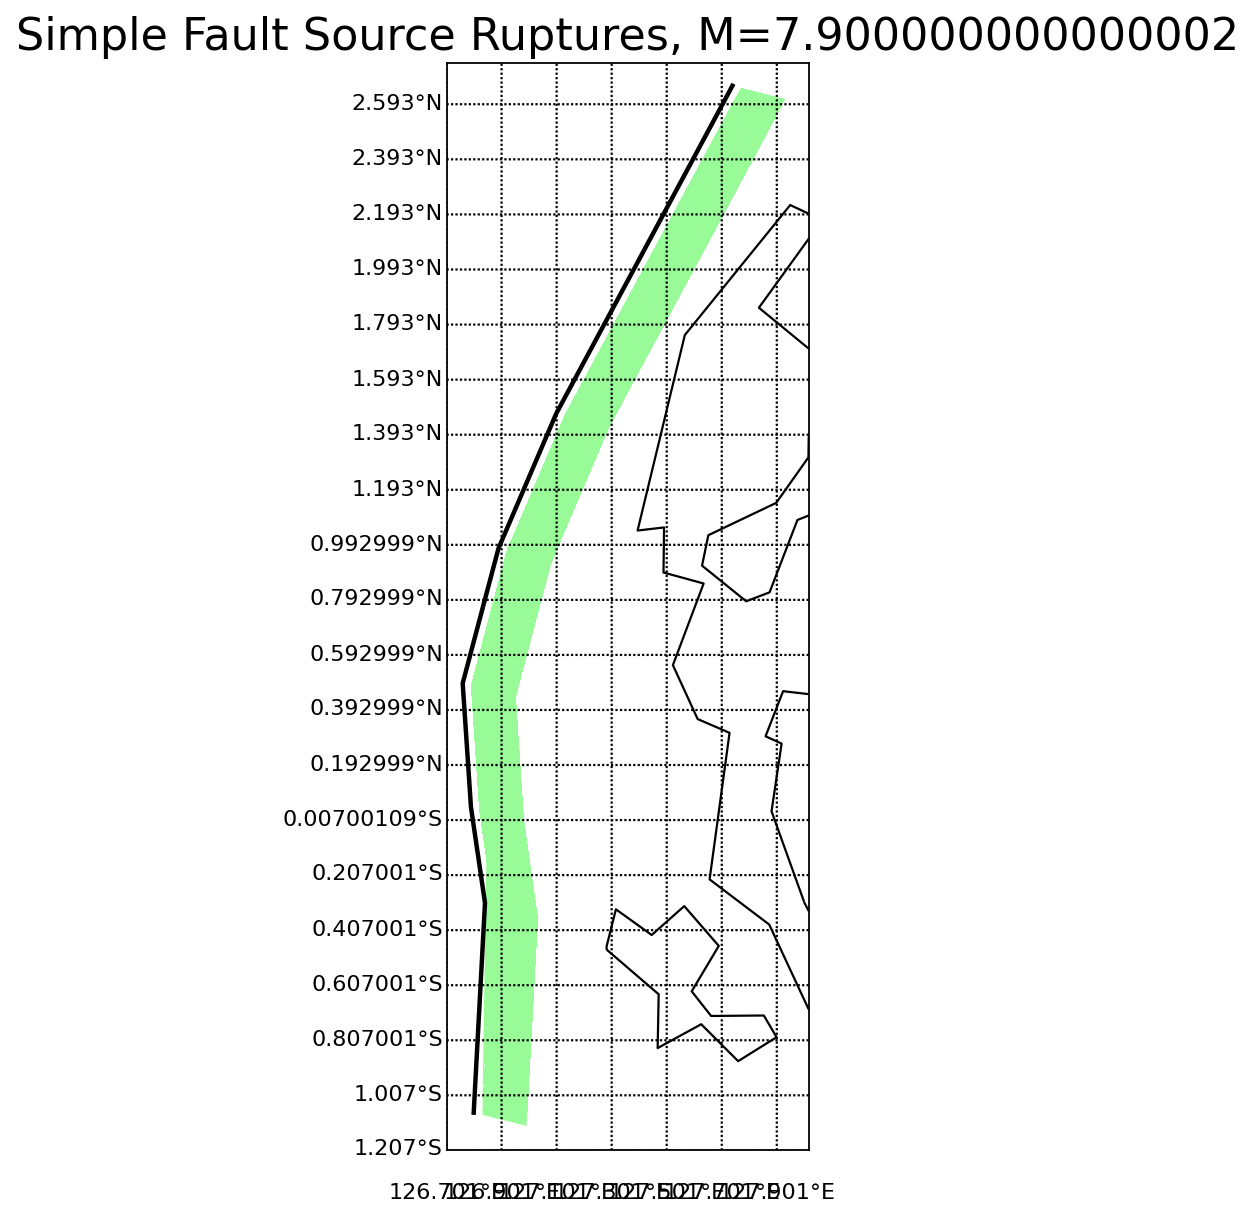

In [8]:
from utility.fault_plot import get_fault_plot

get_fault_plot(src_EMS)

## Set Up Site Characteristic (Vs30)

In [28]:
import pandas as pd

_vs30_table = pd.read_csv("../../vs30/vs30_usgs.csv")
_vs30_table.columns = ["lon","lat","vs30"]

_vs30_table

lon       lat        vs30
0      125.008333  4.091667         600
1      125.016667  4.091667         600
2      125.025000  4.091667         600
3      125.033333  4.091667         600
4      125.041667  4.091667         600
...           ...       ...         ...
20154  126.125000  2.900000  2147483647
20155  126.133333  2.900000  2147483647
20156  126.141667  2.900000  2147483647
20157  126.150000  2.900000  2147483647
20158  126.158333  2.900000  2147483647

[20159 rows x 3 columns]

In [30]:
# filter to remove Vs30 > 2197
vs30_table = _vs30_table[_vs30_table.vs30 <= 2197]
vs30_table

lon       lat  vs30
0      125.008333  4.091667   600
1      125.016667  4.091667   600
2      125.025000  4.091667   600
3      125.033333  4.091667   600
4      125.041667  4.091667   600
...           ...       ...   ...
20013  126.116667  2.908333   600
20014  126.125000  2.908333   600
20015  126.133333  2.908333   600
20016  126.141667  2.908333   600
20017  126.150000  2.908333   600

[19734 rows x 3 columns]

In [59]:
from openquake.hazardlib import site
from openquake.hazardlib.geo.point import Point

site_col = [site.Site(location=Point(x, y), vs30=z) for x,y,z in zip(vs30_table['lon'], vs30_table['lat'], vs30_table['vs30'])]

sites = site.SiteCollection(site_col)

## Define GMPE

In [37]:
from openquake.hazardlib.gsim.abrahamson_silva_1997 import AbrahamsonSilva1997

gmpe_model = {"Active Shallow Crust": AbrahamsonSilva1997()}

## define IML and IMT

In [40]:
imt_lit = ["PGA", "SA(1.0)"]
pga_iml = [0.001, 0.01, 0.02, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 2.0] 
sa1_iml = [0.001, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 1.5] 
iml_list = [pga_iml, sa1_iml]

## runs PSHA

In [41]:
from openquake.hazardlib.calc.hazard_curve import calc_hazard_curves

haz_curves = calc_hazard_curves(
    groups=[src_WMS],
    srcfilter=sites,
    imtls={'PGA': pga_iml},
    gsim_by_trt=gmpe_model,
    truncation_level=None
)

In [49]:
# save the result
import numpy
numpy.save("WMS_haz_curv.npy", haz_curves, allow_pickle=True)

Text(0, 0.5, 'Probability of exceedance in 50 years')

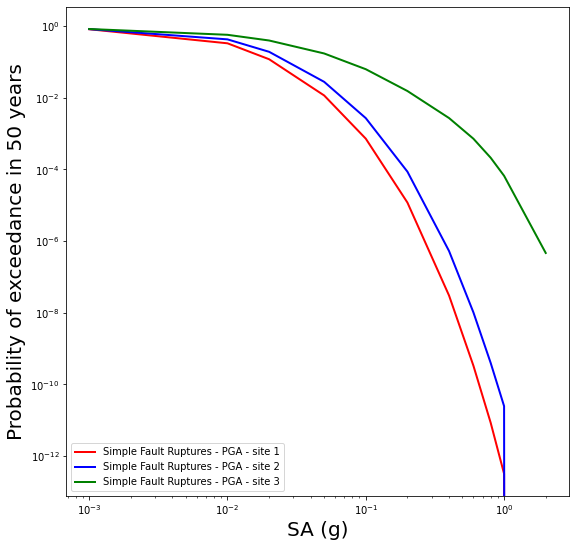

In [51]:
from matplotlib import pyplot
fig = pyplot.figure(figsize=(9, 9))
pyplot.loglog(pga_iml, haz_curves['PGA'][0], '-r', linewidth=2, label='Simple Fault Ruptures - PGA - site 1')
pyplot.loglog(pga_iml, haz_curves['PGA'][5000], '-b', linewidth=2, label='Simple Fault Ruptures - PGA - site 2')
pyplot.loglog(pga_iml, haz_curves['PGA'][15000], '-g', linewidth=2, label='Simple Fault Ruptures - PGA - site 3')
pyplot.legend(loc="lower left")
pyplot.xlabel('SA (g)', fontsize=20)
pyplot.ylabel('Probability of exceedance in 50 years', fontsize=20)

## Disagregate

In [102]:
from openquake.hazardlib.calc import disaggregation, mag_dist_pmf
from openquake.hazardlib.site import Site, SiteCollection
from openquake.hazardlib.imt import PGA

In [89]:
# disaggregate ground motion value corresponding to 0.1 poe
poes = haz_curves['PGA'][0]
iml = numpy.interp([0.1], poes[::-1], pga_iml[::-1])
site = Site(location=Point(vs30_table['lon'][0], vs30_table['lat'][0]), vs30=vs30_table['vs30'][0])

(mags, dists, lons, lats, eps, trts), diss_matrix = disaggregation(
    sources=[src_WMS],
    site=site,
    imt=PGA(),
    iml=iml[0],
    gsim_by_trt={'Active Shallow Crust': AbrahamsonSilva1997()},
    truncation_level=3,
    n_epsilons=3,
    mag_bin_width=0.5,
    dist_bin_width=20.,
    coord_bin_width=.2
)

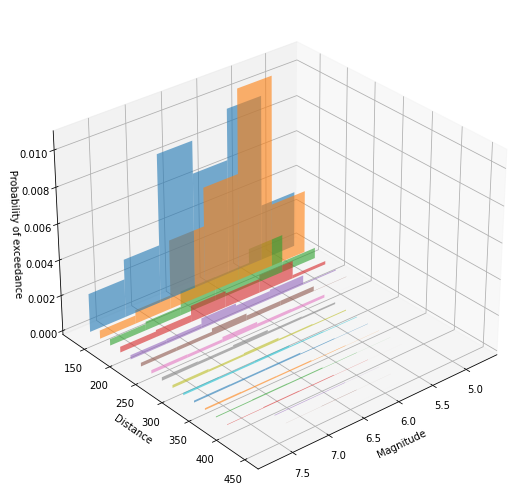

In [106]:
# compute magnitude distance disaggregation
mag_dist = mag_dist_pmf(diss_matrix)
mag_dist = mag_dist.T

fig = pyplot.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')

y_ticks = (dists[: -1] + dists[1:]) / 2
for i, row in enumerate(mag_dist):
    ax.bar(mags[:-1], row, y_ticks[i], zdir='y', alpha=0.6, width=0.5)

ax.set_xlabel('Magnitude')
ax.set_ylabel('Distance')
ax.set_zlabel('Probability of exceedance')
ax.view_init(azim=50.)

In [105]:
def mag_dist_pmf(matrix):
    """
    Fold full disaggregation matrix to magnitude / distance PMF.

    :returns:
        2d array. First dimension represents magnitude histogram bins,
        second one -- distance histogram bins.
    """
    nmags, ndists, nlons, nlats, neps, ntrt = matrix.shape
    mag_dist_pmf = numpy.zeros((nmags, ndists))
    for i in range(nmags):
        for j in range(ndists):
            mag_dist_pmf[i, j] = numpy.prod(
                [1. - matrix[i, j, k, l, m]
                 for k in range(nlons)
                 for l in range(nlats)
                 for m in range(neps)])
    return 1. - mag_dist_pmf

In [95]:
a = numpy.array([[1,2,3],[4,5,6],[7,8,9],[10,11,12],[1,2,3],[4,5,6],[7,8,9],[10,11,12]])
a.shape

(8, 3)

In [104]:
a,b,c,d,e,f = diss_matrix.shape